# Tutorial 1 - WaveBot
The goal of this tutorial is to familiarize new users with how to set up and run optimization problems using WecOptTool. 
This tutorial uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

At the end of this tutorial the user will perform control co-design of the WEC geometry and a corresponding optimal controller to maximize electrical power. 
We build up to this problem in three parts of successive complexity:

1. [Optimal control for maximum mechanical power](#1.-Optimal-control-for-maximum-mechanical-power)
2. [Optimal control for maximum electrical power](#2.-Optimal-control-for-maximum-electrical-power)
3. [Control co-design of the WEC's geometry for maximum electrical power](#3.-Control-co-design-of-the-WEC-geometry-for-maximum-electrical-power)

We will start by loading the necessary modules: 

* Import Autograd (wrapper on NumPy, required) for [automatic differentiation](https://sandialabs.github.io/WecOptTool/theory.html#automatic-differentiation)
* Import other packages we will use in this tutorial
* Import WecOptTool 

In [5]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 1. Optimal control for maximum mechanical power
This example illustrates how to set up, run, and analyze a basic optimization problem using WecOptTool.

The objective of this example is to **find the optimal PTO force time series** that produces the most mechanical power subject to the WEC dynamics and a maximum force the PTO can exert.

WecOptTool requires the following to be defined to successfully run its optimization routines:

* The wave environment
* The WEC object, including all of its properties and constraints
* The objective function

The graphic below shows all the requirements for this first part of the tutorial: the wave environment on the left, the WEC object(with its relevant subcomponents) in the blue box in the middle, and the objective function (mechanical power) on the right.

<div>
<img src="https://live.staticflickr.com/65535/52435098523_37d6a2ca94_k.jpg" width="1000">
</div>

### Waves and WEC geometry
The pseudo-spectral solution used in WecOptTool requires a specified set of frequencies to analyze.
To model the WEC accurately, we need to ensure the set of selected frequencies captures the full hydrodynamic response range of the WEC.

Therefore, we start our WecOptTool model by defining this set of frequencies, the wave environment, and the mesh of the WEC geometry.
This ensures the minimum wavelength in the selected frequencies is larger than the minimum wavelength that can be analyzed with the mesh using the Boundary Element Method (BEM), which we will do [later](#bem-solution).
This is a good initial check to make sure the hydrodynamic properties results calculated with the BEM will be accurate.

#### Frequency selection
To start with a simple case in this tutorial, we are interested in modeling a regular wave at 0.3 Hz.
In regular waves, the linear WEC system response will always occur at the wave frequency, with the nonlinear system response also occurring at the corresponding odd harmonics (3rd, 5th, etc.) of the wave frequency.
Thus, we can set the fundamental frequency in our set, $f_1$, equal to the wave frequency.
Prior WaveBot analysis has found that the nonlinear dynamics are sufficiently captured with the 3rd, 5th, 7th, and 9th harmonics.
WecOptTool assumes the spacing between frequencies equals the magnitude of $f_1$. Therefore, we will model 10 frequencies to encompass these harmonics.

These frequencies will be used for the Fourier representation of both the wave and the desired PTO force in the pseudo-spectral problem.
See the [Theory](https://sandialabs.github.io/WecOptTool/theory.html) section of the WecOptTool documentation for more details on the pseudo-spectral problem formulation.

It is important to use the lowest number of frequencies possible while still maintaining accuracy in order to minimize degrees of freedom and computation time for the optimization solver.

In [6]:
wavefreq = 0.3 # Hz
f1 = wavefreq
nfreq = 10

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

#### Waves
WecOptTool is configured to have the wave environment specified as a 2-dimensional `xarray.DataArray` containing the complex wave amplitudes (in meters), wave phases (in degrees), and directions (in degrees).
We will use an amplitude of 0.0625 meters, a phase of 30 degrees, and direction 0 for this tutorial.
The two coordinates are the radial frequency ``omega`` (in rad/s)  and the direction ``wave_direction`` (in radians).

The `xarray` package has a pretty steep learning curve, so WecOptTool includes the `waves` module containing more intuitive functions that create `xarray.DataArray` objects for different types of wave environments.
See the `xarray` documentation [here](https://docs.xarray.dev/en/latest/index.html) if you are interested in learning more about the package.
In this case, we will use the `wecopttool.waves.regular_wave` function with our wave frequency, amplitude, phase, and direction:

In [7]:
amplitude = 0.0625 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.
The WaveBot mesh is pre-defined in the `wecopttool.geom` module, so we will call it directly from there.
Note that the Capytaine `from_meshio` method can also import from other file types (STL, VTK, MSH, etc.), click [here](https://pypi.org/project/meshio/) for the full list of compatible mesh file types.

In [8]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")

We can also visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
These methods are interactive when used outside a Jupyter notebook.  
The included WaveBot example also has a method for plotting the cross-section of the device, `plot_cross_section`. 

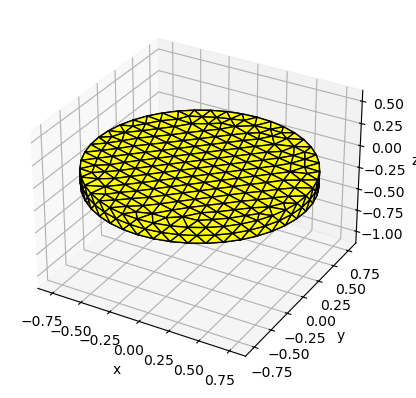

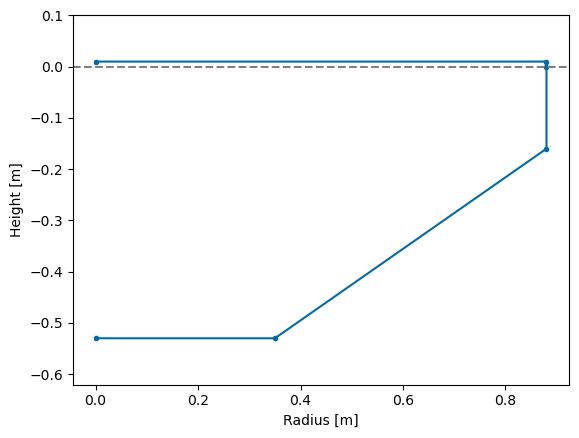

In [9]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True) # specific to WaveBot

#### Minimum wavelength check
With the frequency vector, wave environment, and geometry mesh all defined, we can now check to make sure they are all suitable to accurately simulate the WEC dynamics.
The `fb.minimal_computable_wavelength` method checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine.
We compare this value to the minimum wavelength our frequency vector will compute; we want this number to be <u>larger</u> than Capytaine's minimum wavelength.
A warning is printed if this is not the case.
This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [10]:
min_computable_wavelength = fb.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

### WEC object
The `WEC` object in WecOptTool contains all the information about the WEC and its properties and dynamics.
This constitutes the vast majority of the setup required to run a WecOptTool optimization.
The WEC object handles three categoreis of data that are passed on to the optimizer:

1. The intrinsic impedance of the WEC
2. The WEC and PTO kinematic
3. The PTO dynamics

In order for the `WEC` object to be able to compute these data, we must provide information when we declare the object in the code.
The required information includes:

* [Degrees of freedom to consider](#degrees-of-freedom)
* [Linear hydrodynamic coefficients](#bem-solution)
* Any additional loads (e.g. PTO force, mooring, non-linear hydrodynamics)
* Device constraints

Again, we will keep things simple to start.
We will only consider heave motion and assume a lossless PTO, and the WaveBot has trivial WEC-PTO kinematics (unity).
We will apply one additional force (the PTO force on the WEC) and one constraint (the maximum PTO force), which [we define below using the PTO class](#pto).

#### Degrees of freedom
The degrees of freedom can be added directly to the `FloatingBody` using the `add_translation_dof` and `add_rotation_dof` methods. The axis of rotation is automatically defined if the method is supplied a name of `"Surge"`, `"Sway"`, `"Heave"`, `"Roll"`, `"Pitch"`, or `"Yaw"`. We will only model the heave degree of freedom in this case.

In [11]:
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

#### BEM solution

We can use the `FloatingBody` and frequency vector created earlier to run the Boundary Element Method solver in Capytaine to get the hydrostatic and hydrodynamic coefficients of our WEC object.
This is wrapped into the `wecopttool.run_bem` function.

If you would like to save the BEM data to a NetCDF file for future use, uncomment the second line of the cell below to use the `wot.write_netcdf` function.

In [12]:
bem_data = wot.run_bem(fb, freq)
# wot.write_netcdf('bem_data.nc', bem_data) # saves BEM data to file

[22:47:56] WARNING  Precomputing tabulation, it may take a few seconds.

[22:48:23] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

           WARNING  FloatingBody has no inertia_matrix field. If the FloatingBody mass is defined, it will be used 
                    for calculating the inertia matrix here. Otherwise, the neutral buoyancy assumption will be    
                    used to auto-populate.

           WARNING  FloatingBody has no hydrostatic_stiffness field. Capytaine will auto-populate the hydrostatic  
                    stiffness based on the provided mesh.

The resolution of the mesh might be insufficient for omega ranging from 9.425 to 18.850.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 12 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 9.425 to 18.850.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Irregular frequencies might be encountered for omega ranging from 5.655 to 18.850.
Setting a lid for the floating body is recommended.


           WARNING  Irregular frequencies for 16 problems:                                                         
                    Irregular frequencies might be encountered for omega ranging from 5.655 to 18.850.             
                    Setting a lid for the floating body is recommended.

Output()

Next, we use the utilities class `wecopttool.utilities`, which has functions that help you analyze and design WECs, but are not needed for the core function of WecOptTool.
For example, we calculate the WEC's intrinsic impedance with its hydrodynamic coefficients and inherent inertial properties. We make use of `wecopttool.add_linear_friction()` to convert the `bem_data` into a dataset which contains all zero friction data, because `wecopttool.check_radiation_damping()` and `wecopttool.hydrodynamic_impedance()` excpect a data variable called 'friction'.

The intrinsic impedance tells us how a hydrodynamic body responds to different excitation frequencies. For oscillating systems we are intersted in both, the amplitude of the resulting velocity as well as the phase between velocity and excitation force. Bode plots are useful tool to visualize the frequency response function.

The natural frequency reveals itself as a trough in the intrinsic impedance for restoring degrees of freedom (heave, roll, pitch).

[22:48:24] WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [5 7 8 9] to a minimum of 1e-06 N/(m/s)

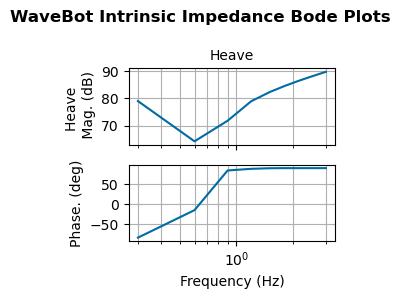

In [13]:
hd = wot.add_linear_friction(bem_data, friction = None) 
#we're not actually adding friction, but need the datavariables in hd 
hd = wot.check_radiation_damping(hd)

intrinsic_impedance = wot.hydrodynamic_impedance(hd)
fig, axes = wot.utilities.plot_bode_impedance(intrinsic_impedance,
                                              'WaveBot Intrinsic Impedance')

#### PTO
WecOptTool includes the `PTO` class to encompass all properties of the power take-off system of the WEC.
Data wrapped into our `PTO` class will be used to provide the additional force and constraint for our `WEC` object definition, as well as our optimization problem later.

To create an instance of the `PTO` class, we need:

* The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom.
In this case, the PTO extracts power directly from the heaving motion of the WEC, so the kinematics matrix is simply a $1 \times 1$ identity matrix.
* The definition of the PTO controller.
The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force.
However, we will be using an unstructured controller in this case, which is the default when `controller=None`.
* Any PTO impedance.
We are only interested in mechanical power for this first problem, so we will leave this empty for now.
* The non-linear power conversion loss (assumed 0% if `None`)
* The PTO system name, if desired

In [14]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

Now we define the PTO forcing on the WEC and the PTO constraints.
We set the maximum PTO force as 750 Newtons.
This value is chosen somewhat arbitrary to highlight different effects throughout this tutorial.
In practice, the user would need to identify their limiting component in the PTO and then compute a suitable value.
For example, if the generator drive has a maximal current $I_{max}$ of 10 A, with a generator torque constant $K_t$ of 8 Nm/A and a gear ratio $N$ of 9 rad/m, this results in a max PTO linear force of $F = N K_{t} I_{max} = 9$ rad/m $\times 8$ Nm $\times 10$ A $= 720$ N.

We will enforce the constraint at 4 times more points than the dynamics; see [Theory]((https://sandialabs.github.io/WecOptTool/theory.html)) for why this is helpful for the pseudo-spectral problem.
The constraints must be in the correct format for `scipy.optimize.minimize`, which is the solver WecOptTool uses. See the documentation for the solver [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and note the matching syntax of `ineq_cons` below.

In [15]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 750.0
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

#### `WEC` creation
We are now ready to create the `WEC` object itself!
Since we ran the BEM already, we can define the object using the `wecopttool.WEC.from_bem` function.
If we saved BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [16]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

[22:48:25] WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [5 7 8 9] to a minimum of 1e-06 N/(m/s)

_Note: You may receive a warning regarding negative linear damping values._
_By default, WecOptTool ensures that the BEM data does not contain non-negative damping values._
_If you would like to correct the BEM solution to a different minimum damping value besides zero, you can specify_ `min_damping`.

### Objective function
The objective function is the quantity we want to optimize—in this case, the average mechanical power.
The function to compute this can be taken directly from the `PTO` object we created:

In [17]:
obj_fun = pto.mechanical_average_power

The objective function is itself a function of the optimization state `x_opt`.
The length of `x_opt`, `nstate_opt`, needs to be properly defined to successfully call `scipy.optimize.minimize`.
In other words, it should match the quantities we are interested in optimizing.
In this case, we are optimizing for the control trajectories of an unstructured PTO, which can be represented in the Fourier domain by the DC (zero frequency) component, then the real and imaginary components for each frequency.

In [18]:
nstate_opt = 2*nfreq

One technical quirk here: `nstate_opt` is one smaller than would be expected for a state space representing the mean (DC) component and the real and imaginary Fourier coefficients.
This is because WecOptTool excludes the imaginary Fourier component of the highest frequency (the 2-point wave).
Since the 2-point wave is sampled at multiples of $\pi$, the imaginary component is evaluated as $sin(n\pi); n = 0, 1, 2, ..., n_{freq}$, which is always zero.

### Solve
We are now ready to solve the problem.
WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

The only required inputs for defining and solving the problem are:

1. The wave environment
2. The objective function
3. The size of the optimization state (`nstate_opt`)

Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance.
See the `scipy.optimize.minimize` documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for more details.

To help the problem converge faster, we will scale the problem before solving it (see the [Scaling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) section of the Theory documentation).
WecOptTool allows you to scale the WEC dynamics state, the optimization state, and the objective function separately.
See the `wecopttool.WEC.solve` documentation [here](https://sandialabs.github.io/WecOptTool/api_docs/wecopttool.WEC.solve.html#wecopttool-wec-solve).


Pay attention to the `Exit mode`: an exit mode of `0` indicates a successful solution.
A simple problem (linear, single degree of freedom, unconstrained, etc.) should converge in well under 100 iterations.
If you exceed this, try adjusting the scales by orders of magnitude, one at a time.

In [19]:
options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_mechanical_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.4889166755213465
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimal average mechanical power: -48.89166755213465 W


### Analyzing results
We will use two post-processing functions to obtain frequency and time domain results for the WEC and PTO responses.
The `wec.post_process` and `pto.post_process` functions both post-process the results for each wave phase realization.
The pseudo-spectral method gives continuous in time results.
To get smoother looking plots, we specify five subpoints betweeen co-location points.

In [20]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

The `pto.post_process` function returns a list of `xarray.Dataset` objects, each element of which has built-in integration with PyPlot for smart plotting with automatic titles and formatting.
We will plot the mechanical power (`mech_power`), position (`pos`), and the PTO force (`force`).

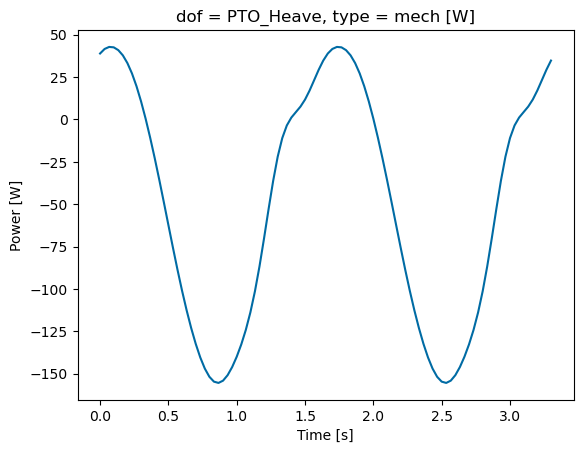

In [21]:
plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()

We could similarly plot any time or frequency domain response of the WEC or PTO by calling the specific type of response (position, velocity, force, etc.).
For example, to plot the WEC heave position and PTO force:

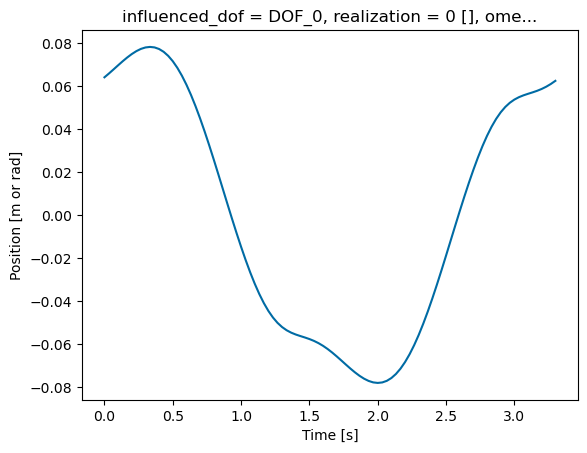

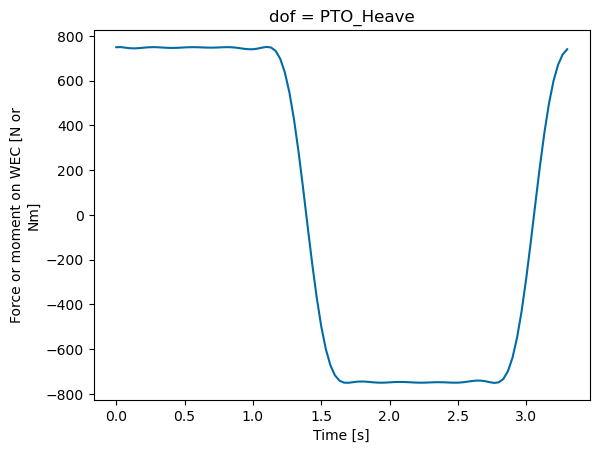

In [22]:
plt.figure()
wec_tdom[0]['pos'].plot()

plt.figure()
pto_tdom[0]['force'].plot()

Note that there are other dynamic responses available in the post-processed WEC and PTO variables (`wec_tdom`, `pto_tdom`, `wec_fdom`, `pto_fdom`).
For example, the time domain PTO variable contains the following response:

In [23]:
pto_tdom

[<xarray.Dataset> Size: 6kB
 Dimensions:  (time: 100, dof: 1, type: 2)
 Coordinates:
   * time     (time) float64 800B 0.0 0.03333 0.06667 0.1 ... 3.2 3.233 3.267 3.3
   * dof      (dof) <U9 36B 'PTO_Heave'
   * type     (type) <U4 32B 'mech' 'elec'
 Data variables:
     pos      (time, dof) float64 800B 0.06403 0.06582 0.0677 ... 0.06091 0.06238
     vel      (time, dof) float64 800B 0.05187 0.05541 ... 0.04088 0.04688
     acc      (time, dof) float64 800B 0.13 0.08122 0.02535 ... 0.189 0.1674
     force    (time, dof) float64 800B 750.0 750.5 747.9 ... 671.5 717.0 741.0
     power    (type, time, dof) float64 2kB 38.9 41.59 42.78 ... 29.31 34.73
 Attributes:
     time_created_utc:  2025-01-12 06:48:26.291162]

Lastly, we will visualize the average power at different stages and how the power flows through the system.


(<Figure size 800x400 with 1 Axes>, <Axes: >)

[22:48:27] WARNING  Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.

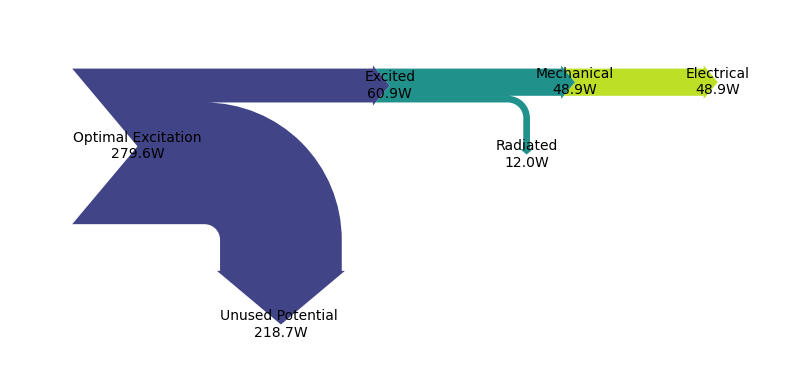

In [24]:
p_flows = wot.utilities.calculate_power_flows(wec,
                                              pto, 
                                              results, 
                                              waves, 
                                              intrinsic_impedance)
wot.utilities.plot_power_flow(p_flows)


On the very left of the power flow Sankey diagram we start with the *Optimal Excitation*, which is only determined by the incident wave and the hydrodynamic damping and friction. 
In order for the actual *Excited* power to equal the *Optimal Excitation* the absorbed *Mechanical* power would need to equal the *Radiated* power (power that is radiated away from the WEC). In this case the *Unused Potential* would be zero.
In other words, you can never convert more than 50% of the incident wave energy into kinetic energy. For more information on this we refer to Johannes Falnes Book - Ocean Waves and Oscillating System, specifically Chapter 6.

However, the optimal 50% absorption is an overly optimistic goal considering that real world systems are likely constrained in their oscillation velocity amplitude and phase, due to limitations in stroke and applicable force.


The PTO force constraint used in this optimization also stopped us from absorbing the maximal potential wave energy. It is notable that we absorbed approximately 3/4 of the maximal absorbable power (*Mechanical* / (1/2 *Optimal Excitation*)), with relatively little *Radiated* power (about 1/2 of the absorbed power). To also absorb the last 1/4 of the potential wave power, we would need to increase the *Radiated* power three times!!


A more important question than "How to achieve optimal absorption?" is "How do we optimize usable output power?", i.e. *Electrical* power. For this optimization case we used a lossless PTO that has no impedance in itself. Therefore, the *Electrical* power equals the absorbed *Mechanical* power.
We'll show in the following sections that this a poor assumption and that the power flow looks fundamentally different when taking the PTO dynamics into account!!


## 2. Optimal control for maximum electrical power

The rest of this tutorial will focus on a different objective function: we will now optimize for <u>electrical</u> power rather than mechanical, as this is a form of power that is usable and transportable.

Since we are still dealing with the same WaveBot as in Part 1, we can reuse the BEM, WEC-PTO kinematics, and wave data from before.

<div>
<img src="https://live.staticflickr.com/65535/52435033525_b8efc28d16_k.jpg" width="1000">
</div>

The biggest difference when considering electrical power is the addition of the PTO dynamics.
In other words, we no longer assume a lossless PTO.
We will express the PTO dynamics in the form of a [2-port impedance model](https://en.wikipedia.org/wiki/Impedance_parameters) to incorporate the dynamics of the drivetrain and generator.
The additional mechanical energy storage through the drivetrain is modeled using Newton's second law, and we assume a linear generator using a power-invariant park transform.

The PTO impedance matrix components are then obtained under open-circuit conditions: no load current ($i_{pto}$ in figure above) or no WEC velocity ($vel_{pto}$ above), respectively.
See Section II of Michelén et al. [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10114969) for more details about how the code below is derived.

In [25]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance_2 = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

Next, we will create a new `PTO` object with this impedance matrix.
We will also update the definitions of our PTO constraint and additional dynamic forcing function to use the new object.
We will again set our maximum PTO force to 750 Newtons in this example, so we do not need to redefine `f_max`.

In [26]:
## Update PTO
name_2 = ['PTO_Heave_Ex2']
pto_2 = wot.pto.PTO(ndof, kinematics, controller, pto_impedance_2, loss, name_2)

## Update PTO constraints and forcing
def const_f_pto_2(wec, x_wec, x_opt, waves):
    f = pto_2.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())
ineq_cons_2 = {'type': 'ineq', 'fun': const_f_pto_2}
constraints_2 = [ineq_cons_2]
f_add_2 = {'PTO': pto_2.force_on_wec}

Finally, we will update our `WEC` object with the new PTO and objective function, then run our optimization problem.
Note we are now using `average_power` instead of `mechanical_average_power` as our objective function.

In [27]:
# Update WEC
wec_2 = wot.WEC.from_bem(bem_data,
                         constraints=constraints_2,
                         friction=None,
                         f_add=f_add_2
)

# Update objective function
obj_fun_2 = pto_2.average_power

# Solve
scale_x_wec = 1e1  
scale_x_opt = 1e-3  
scale_obj = 1e-2  

results_2 = wec_2.solve(
    waves, 
    obj_fun_2, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
opt_average_power = results_2[0].fun
print(f'Optimal average electrical power: {opt_average_power} W')

# Post-process
wec_fdom_2, wec_tdom_2 = wec_2.post_process(wec_2, results_2, waves, nsubsteps)
pto_fdom_2, pto_tdom_2 = pto_2.post_process(wec_2, results_2, waves, nsubsteps)

           WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [5 7 8 9] to a minimum of 1e-06 N/(m/s)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.280049608808263
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimal average electrical power: -28.0049608808263 W


We will compare our optimal results to the unconstrained case to gain some insight into the effect of the constraint on the optimal PTO force.
Let's do the same process as before, but unset the `constraints` parameter in a new `WEC` object.

In [28]:
wec_2_nocon = wot.WEC.from_bem(
    bem_data,
    constraints=None,
    friction=None,
    f_add=f_add_2)

results_2_nocon = wec_2_nocon.solve(
    waves,
    obj_fun_2, 
    nstate_opt,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
opt_average_power = results_2_nocon[0].fun
print(f'Optimal average electrical power: {opt_average_power} W')
wec_fdom_2_nocon, wec_tdom_2_nocon = wec_2_nocon.post_process(
    wec_2_nocon, results_2_nocon, waves, nsubsteps)
pto_fdom_2_nocon, pto_tdom_2_nocon = pto_2.post_process(
    wec_2_nocon, results_2_nocon, waves, nsubsteps)

[22:48:28] WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [5 7 8 9] to a minimum of 1e-06 N/(m/s)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2917608606609582
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Optimal average electrical power: -29.176086066095817 W


Note that the optimal constrained PTO force follows the optimal unconstrained solution (sinusoidal) whenever the unconstrained solution is within the constraint. 
When the constraint is active the optimal PTO force is the maximum PTO force of 750 Newtons.

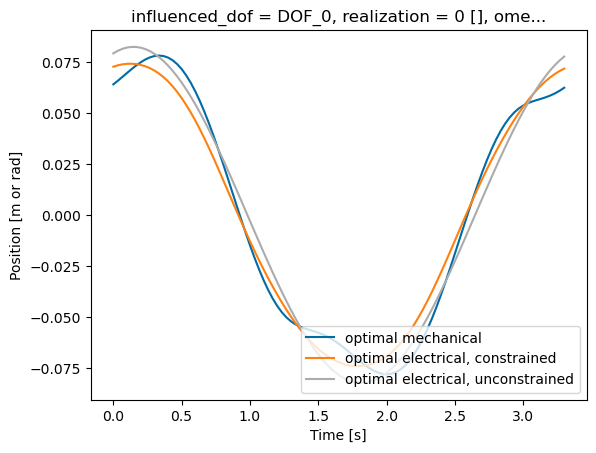

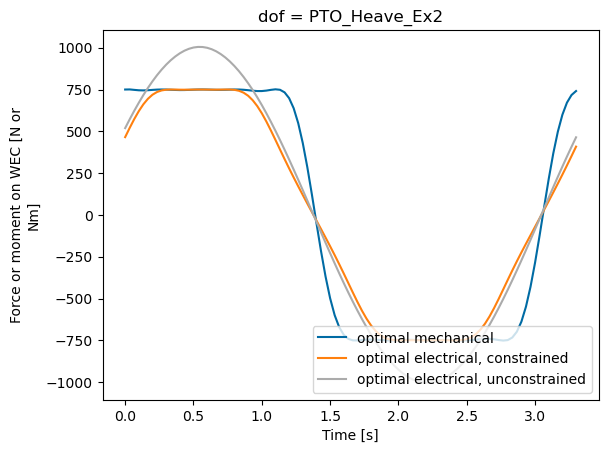

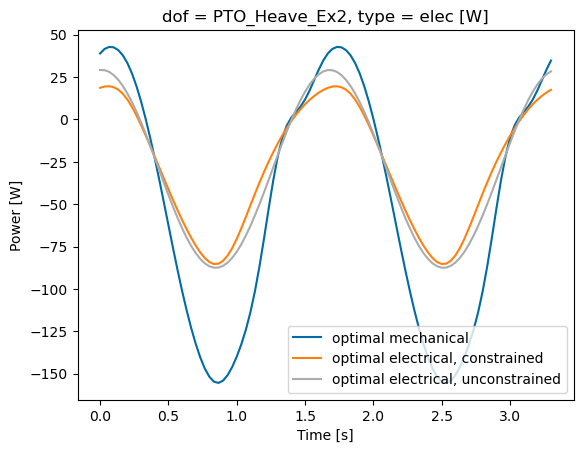

In [29]:
plt.figure()
wec_tdom[0]['pos'].plot(label='optimal mechanical')
wec_tdom_2[0]['pos'].plot(label='optimal electrical, constrained')
wec_tdom_2_nocon[0]['pos'].plot(label='optimal electrical, unconstrained')
plt.legend(loc='lower right')

plt.figure()
pto_tdom[0]['force'].plot(label='optimal mechanical')
pto_tdom_2[0]['force'].plot(label='optimal electrical, constrained')
pto_tdom_2_nocon[0]['force'].plot(label='optimal electrical, unconstrained')
plt.legend(loc='lower right')

plt.figure()
pto_tdom[0]['power'].sel(type='mech').plot(label='optimal mechanical')
pto_tdom_2[0]['power'].sel(type='elec').plot(label='optimal electrical, constrained')
pto_tdom_2_nocon[0]['power'].sel(type='elec').plot(label='optimal electrical, unconstrained')
plt.legend(loc='lower right')


The attentive user might have noticed that the amplitude of the mechanical power is less compared to Part 1 of the tutorial.
We can see that optimizing for electrical power requires optimal state trajectories with less reactive mechanical power (i.e. power that is put into the system).

The PTO force trajectory for optimizing mechanical power is saturated at the maximum for longer compared to the electrical power.
This could inform the WEC designer optimizing for mechanical power to consider larger components that would not be utilized at their limit as frequently.
However, the electrical power (_not_ the mechanical power) is the usable form of power, thus designing the WEC for optimal electrical power does not indicate a need for larger components and prevents this over-design.

The Sankey power flow diagram confirm this observation.

(<Figure size 800x400 with 1 Axes>, <Axes: >)

[22:48:31] WARNING  Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.

           WARNING  Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.

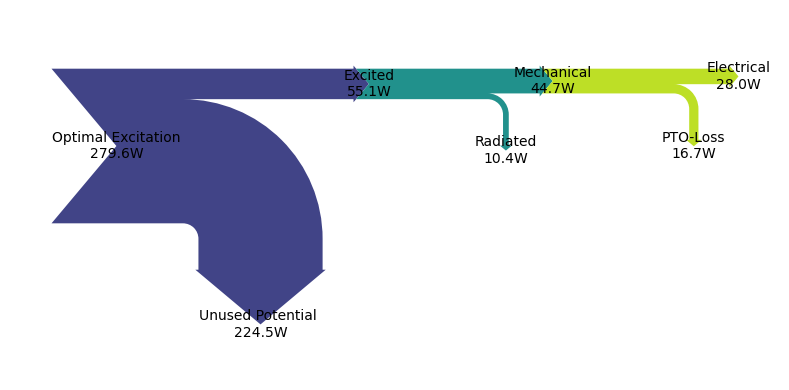

In [30]:
p_flows_2 = wot.utilities.calculate_power_flows(wec_2, pto_2, results_2, waves, intrinsic_impedance)
wot.utilities.plot_power_flow(p_flows_2)

## 3. Control co-design of the WEC geometry for maximum electrical power
The first two examples only used the inner optimization loop in WecOptTool to optimize PTO power.
In Part 3, we bring it all together and show how to use both the inner and outer optimization loops in WecOptTool to do control co-optimization of a hull design in conjunction with an optimal controller for electrical power.

Again, we use the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average produced electrical power, while maintaining a constant hull volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius.

This example demonstrates a complete case of the control co-optimization studies WecOptTool is meant for. 
The inner optimization loop finds the control trajectory that produces the optimal PTO force for a given hull geometry, and the outer optimization loop finds the optimal hull geometry _amongst designs with optimal control trajectories_.

The inner loop is consolidated into the `WEC.solve()` method, but the outer loop needs to be configured by the user for their particular design problem.
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute` (click [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html) for documentation).  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg) 
<div>
<img src="https://live.staticflickr.com/65535/52434071157_187eb4334c_k.jpg" width="1000">
</div>



### Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

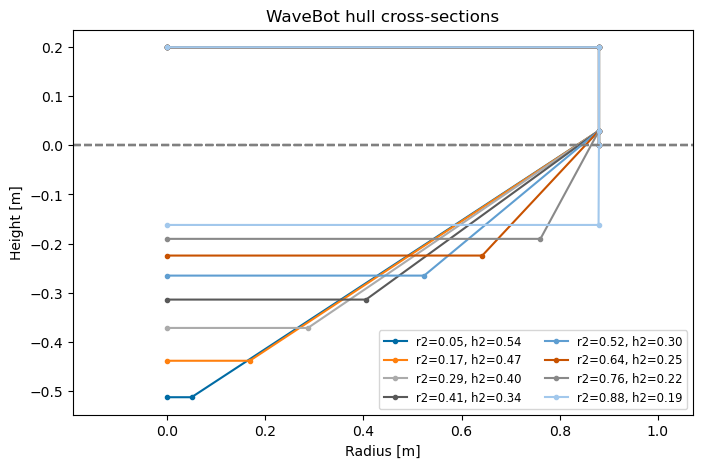

In [31]:
r1 = 0.88
r2_0 = 0.35
h2_0 = 0.37
V0 = 1/3*np.pi*h2_0*(r1**2+r2_0**2+(r1*r2_0))

r2_vals = np.linspace(0.05, 0.88*0.999, 8, endpoint=True)


def h2_from_r2(r2, V=V0, r1=r1):
    h2 = V/(1/3*np.pi*(r1**2+r2**2+(r1*r2)))
    return h2


# plot
mapres = map(h2_from_r2, r2_vals)
h2_vals = list(mapres)

fig1, ax1 = plt.subplots(figsize=(8,5))
for r2, h2 in zip(r2_vals.tolist(), h2_vals):
    _ = wot.geom.WaveBot(r2=r2, h2=h2, freeboard=0.2).plot_cross_section(
        ax=ax1, label=f"r2={r2:.2f}, h2={h2:.2f}")
ax1.legend(loc='best', fontsize='small',ncol=2)
_ = ax1.set_title('WaveBot hull cross-sections')


Next we will define an objective function for our design optimization problem.
We use the same workflow used in Part 2 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which sets `r2` and (indirectly) `h2`.

In [32]:
def design_obj_fun(x):

    # Unpack geometry variables
    r2 = x[0]
    h2 = h2_from_r2(r2)
    print(f"\nr2 = {r2:.2f}:")

    # Set up Capytaine floating body
    wb = wot.geom.WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="Heave")
    ndof = fb.nb_dofs

    # Run BEM
    f1 = 0.05
    nfreq = 50
    bem_data = wot.run_bem(fb, freq)

    # Impedance definition
    omega = bem_data.omega.values
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_inertia = 2.0
    drivetrain_friction = 1.0
    drivetrain_stiffness = 0.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance_3 = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

    # Set PTO object
    name = ["PTO_Heave",]
    kinematics = np.eye(ndof)
    efficiency = None
    controller = None
    pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance_3, efficiency, name)
    

    # Set PTO constraint and additional dynamic force
    nsubsteps = 4
    f_max = 750.0

    def const_f_pto(wec, x_wec, x_opt, waves):
        f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq', 'fun': const_f_pto}
    constraints = [ineq_cons]

    f_add = {'PTO': pto.force_on_wec}

    # Create WEC
    wec = wot.WEC.from_bem(bem_data,
            constraints=constraints,
            friction=None, 
            f_add=f_add,
            )

    # Objective function
    obj_fun = pto.average_power
    nstate_opt = 2*nfreq
    
    # Solve
    scale_x_wec = 1e1  
    scale_x_opt = 1e-3  
    scale_obj = 1e-2  
    res = wec.solve(
        waves, 
        obj_fun, 
        nstate_opt, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj)

    return res[0].fun

### Solve
Finally, we call our wrapped function using `scipy.optimize.brute`.
The optimization algorithm will call our objective function, which in turn will create a new WaveBot hull, run the necessary BEM calculations for the hull, and find the PTO force that provides the most electric power for that hull. 
This process will be conducted for the range of `r2` values that we specify.

_(note: the cell below will take longer to run than the cells above, up to several minutes)_

In [33]:
wot.set_loglevel("error")  # Suppress warnings

# range over which to search
ranges = (slice(r2_vals[0], r2_vals[-1]+np.diff(r2_vals)[0], np.diff(r2_vals)[0]),)

# solve
opt_x0, opt_fval, x0s, fvals = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)


r2 = 0.05:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2798707736215192
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10

r2 = 0.17:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.27979769701488083
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10

r2 = 0.29:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.27991864966433566
            Iterations: 9
            Function evaluations: 10
            Gradient evaluations: 9

r2 = 0.41:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2801760535897517
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10

r2 = 0.52:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2807033488095473
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10

r2 = 0.64:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.28161921840753684
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10

r2 = 0.76:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2834232562102313
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11

r2 = 0.88:


Output()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.28739402874874664
            Iterations: 9
            Function evaluations: 9
            Gradient evaluations: 9


### Results
From a quick plot of the results, we see that the power absorption (where negative power is power absorbed by the device) generally improves for larger values of `r2`.

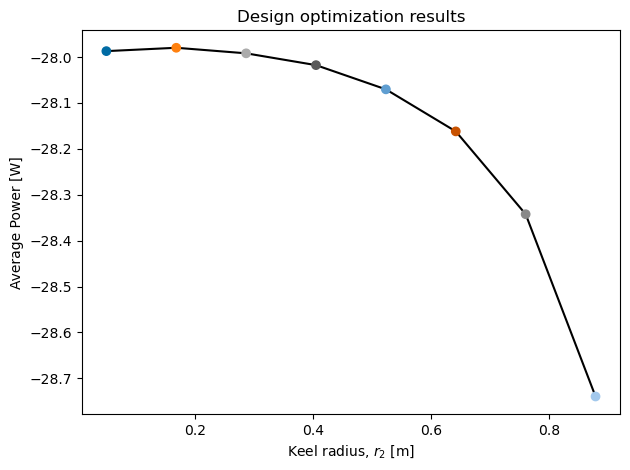

In [34]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(x0s)]
ax.plot(x0s, fvals, 'k', zorder=0)
ax.scatter(x0s, fvals, c=colors, zorder=1)

ax.set_xlabel('Keel radius, $r_2$ [m]')
ax.set_ylabel('Average Power [W]')
ax.set_title('Design optimization results')
fig.tight_layout()

Note that in this case the difference in average power between the different keel radii is rather small.
This is because the PTO force constraint is active most of the time, therefore all considered geometries perform similarily.
If you remove the PTO constraint and re-run the co-optimization study, you will see that the impact of radius on average electrical power is significantly higher.

In [35]:
print(results_2)

[ message: Optimization terminated successfully
 success: True
  status: 0
     fun: -28.0049608808263
       x: [ 6.324e-06  7.491e-02 ... -6.380e-01 -2.026e-01]
     nit: 10
     jac: [ 0.000e+00 -6.585e+02 ...  4.928e-05 -2.089e-05]
    nfev: 10
    njev: 10]
